In [28]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [29]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

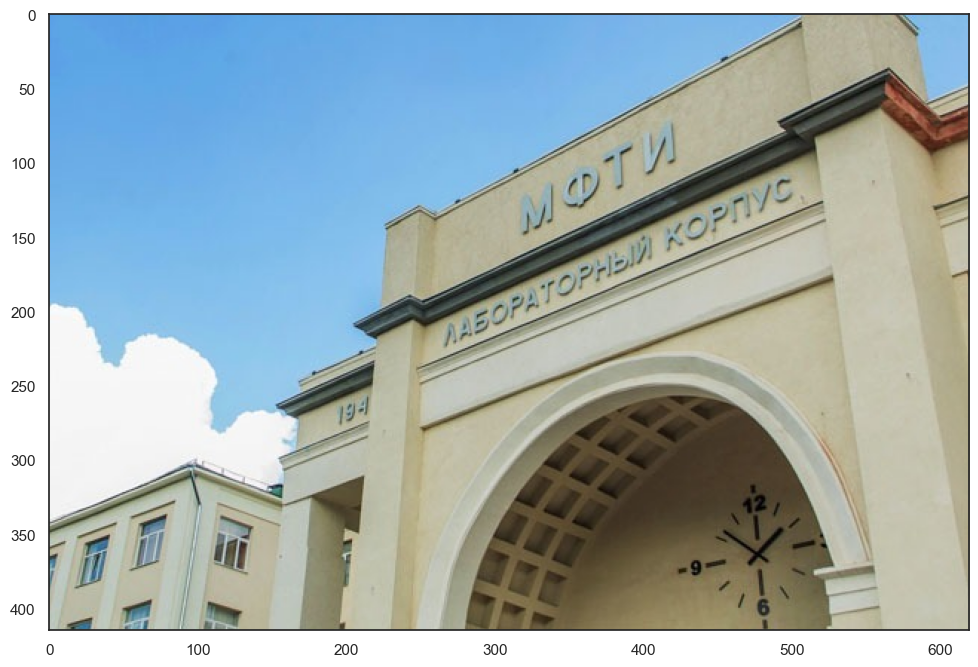

In [30]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

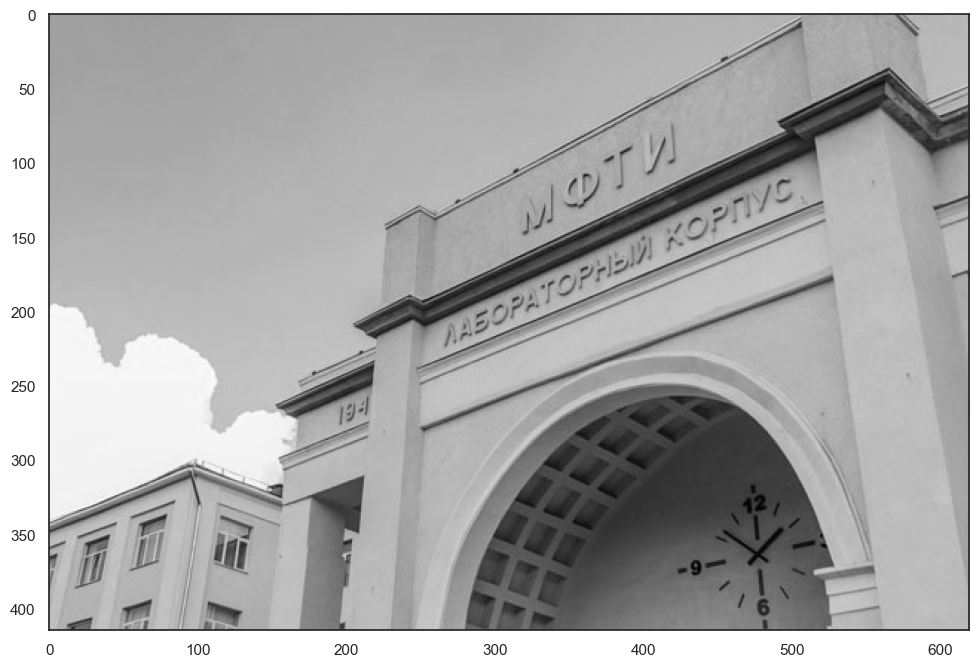

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79296875..1.0351562].


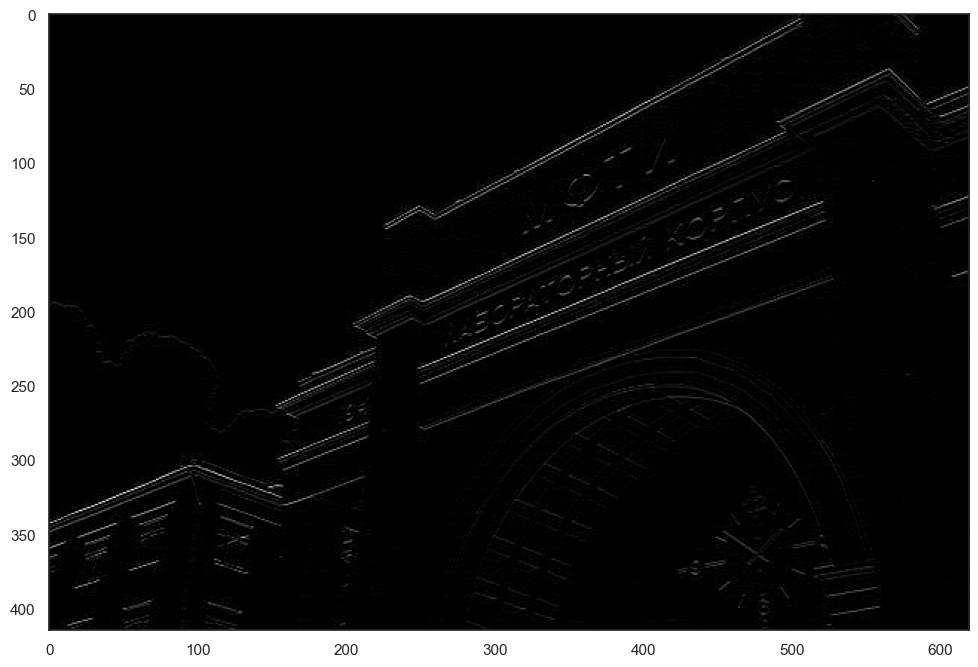

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.76692706..0.81901044].


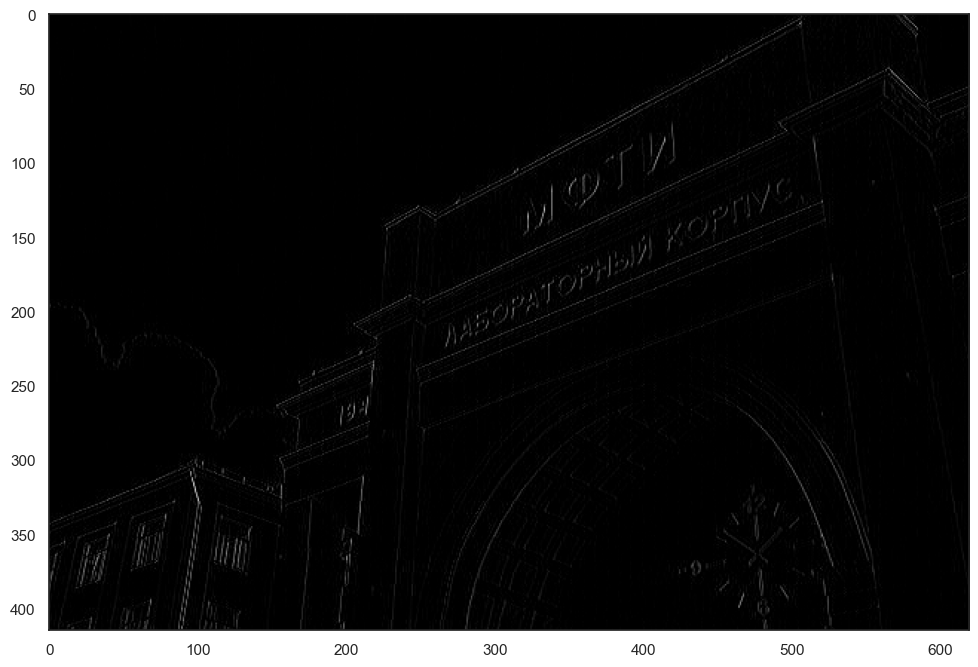

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1679688..1.4140625].


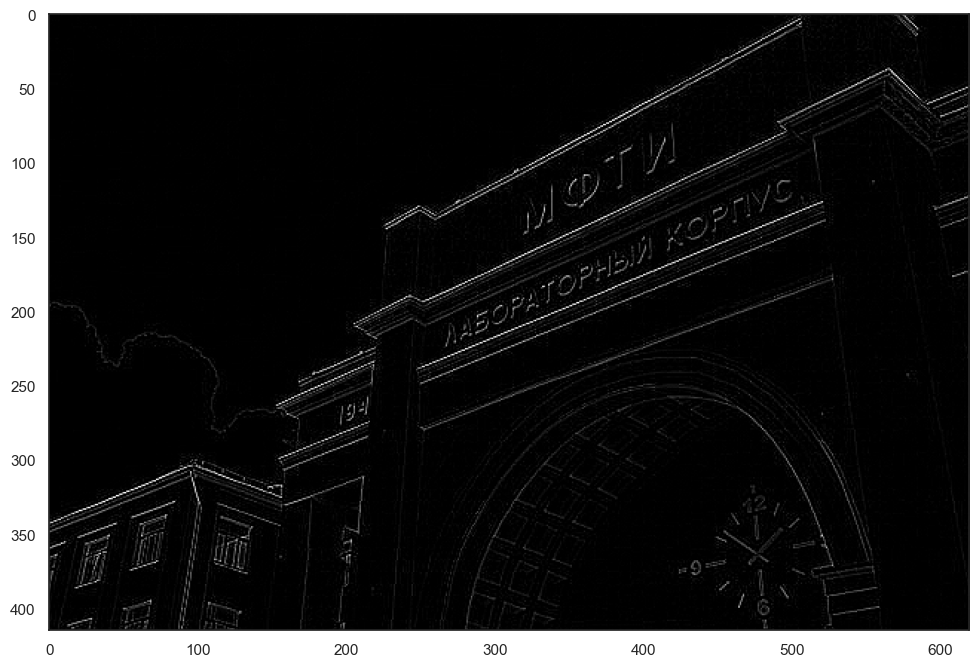

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2005209..2.0546875].


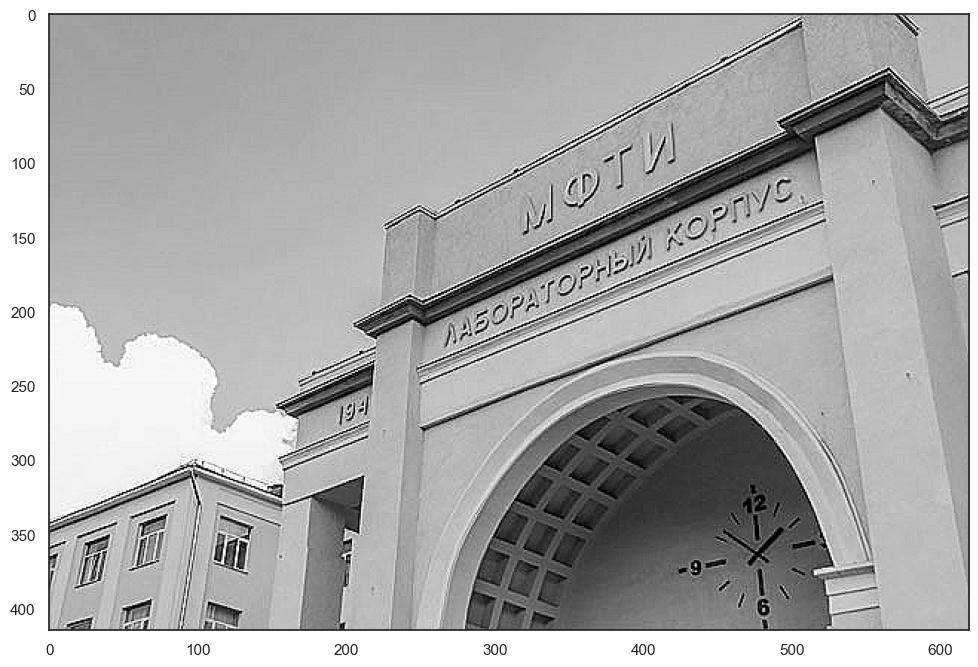

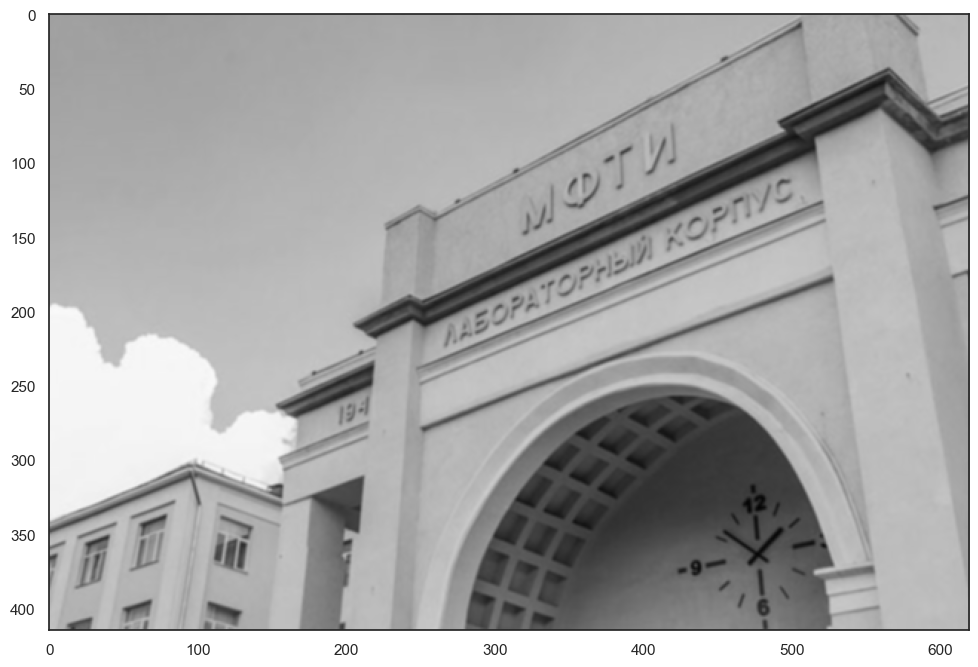

In [31]:
kernels = [
    torch.tensor([
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]
    ]).reshape(1, 1, 3, 3).type(torch.float32),
    torch.tensor([
        [0, 1, 0],
        [0, -2, 0],
        [0, 1, 0]
    ]).reshape(1, 1, 3, 3).type(torch.float32),
    torch.tensor([
        [0, 0, 0],
        [1, -2, 1],
        [0, 0, 0]
    ]).reshape(1, 1, 3, 3).type(torch.float32),
    torch.tensor([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ]).reshape(1, 1, 3, 3).type(torch.float32),
    torch.tensor([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ]).reshape(1, 1, 3, 3).type(torch.float32),
    torch.tensor([
        [0.0625, 0.125, 0.0625],
        [0.125, 0.25, 0.125],
        [0.0625, 0.125, 0.0625]
    ]).reshape(1, 1, 3, 3).type(torch.float32)
]
for kernel in kernels:
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)

    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

    result = F.conv2d(img_t, kernel)[0]
    # print((result[0] - result[1]).abs().max())
    plt.figure(figsize=(12, 8))
    result_np = (result.permute(1, 2, 0).numpy() / 256 / 3)

    plt.imshow(result_np)
    plt.show()

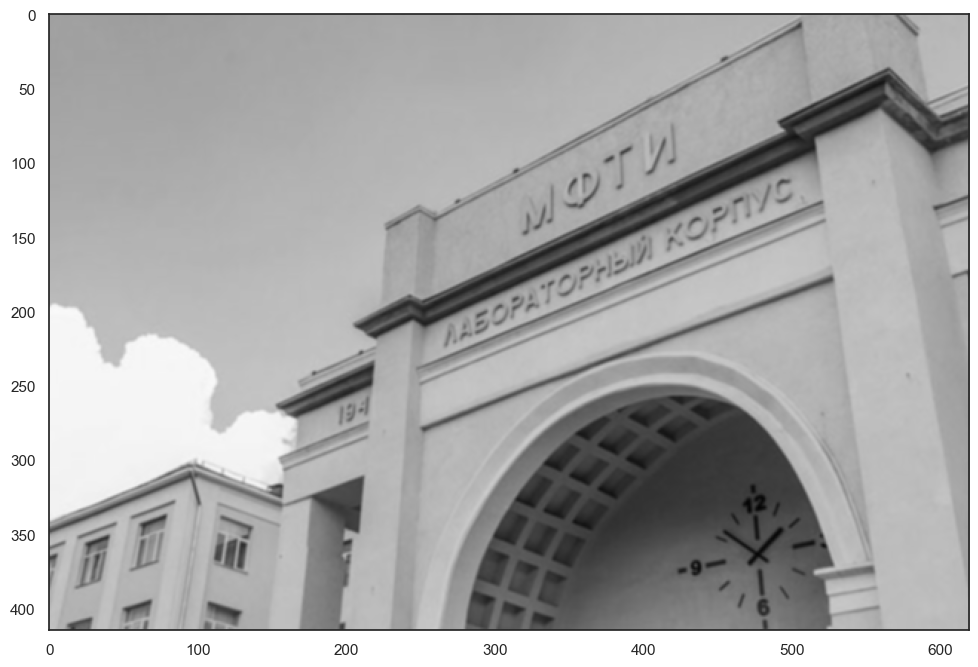

In [32]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие 

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** ЕДАВБГ

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [33]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [34]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [35]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch + 1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all}")
        accuracy[k].append(epoch_correct / epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9138166666666667
Loader: valid. Accuracy: 0.9751
Epoch: 2
Loader: train. Accuracy: 0.9780166666666666
Loader: valid. Accuracy: 0.9822
Epoch: 3
Loader: train. Accuracy: 0.9844666666666667
Loader: valid. Accuracy: 0.9854
Epoch: 4
Loader: train. Accuracy: 0.9879333333333333
Loader: valid. Accuracy: 0.988
Epoch: 5
Loader: train. Accuracy: 0.9904833333333334
Loader: valid. Accuracy: 0.9889
Epoch: 6
Loader: train. Accuracy: 0.99185
Loader: valid. Accuracy: 0.9862
Epoch: 7
Loader: train. Accuracy: 0.9931833333333333
Loader: valid. Accuracy: 0.9886
Epoch: 8
Loader: train. Accuracy: 0.99385
Loader: valid. Accuracy: 0.988
Epoch: 9
Loader: train. Accuracy: 0.9946166666666667
Loader: valid. Accuracy: 0.9895
Epoch: 10
Loader: train. Accuracy: 0.9954
Loader: valid. Accuracy: 0.9885


In [36]:
lenet_accuracy = accuracy["valid"]

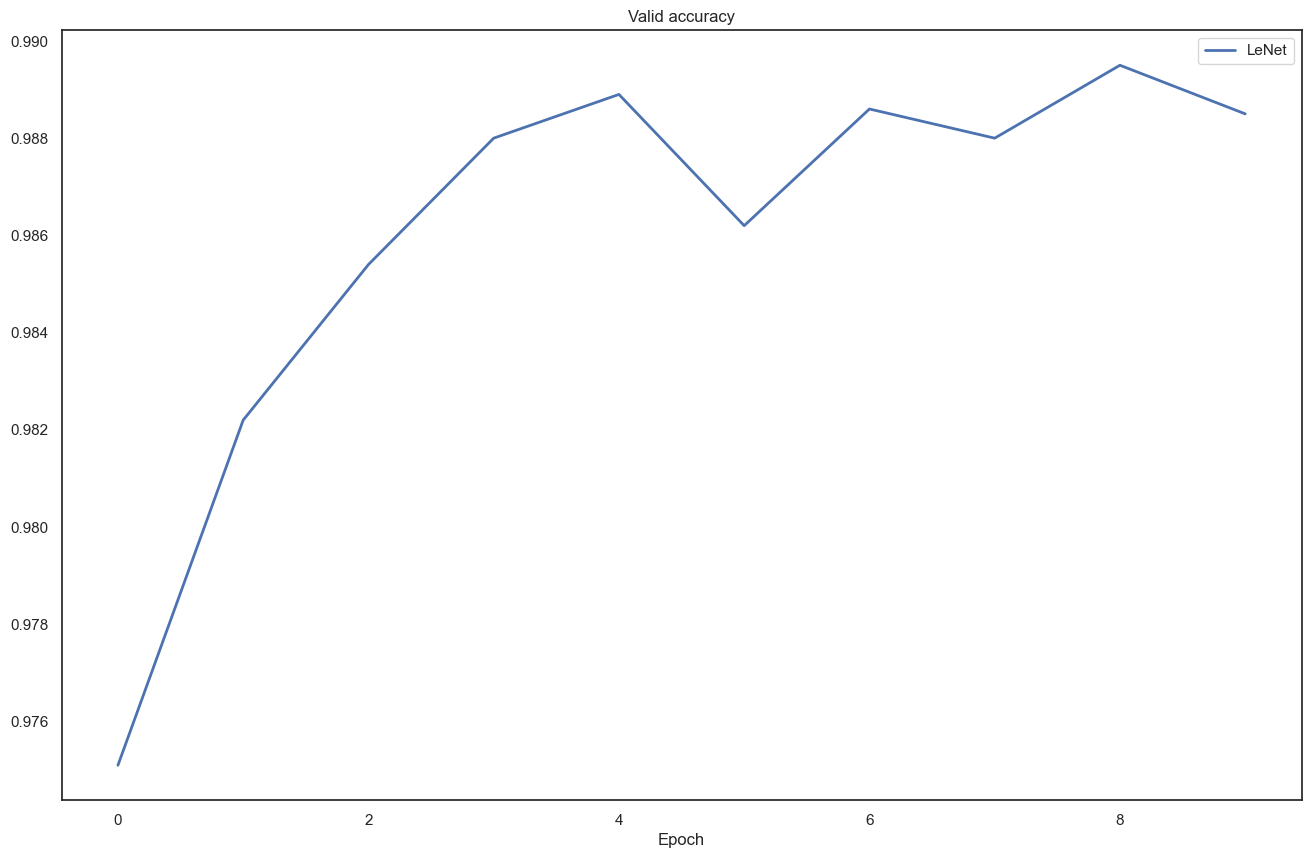

In [38]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99